# Regression via simulation; variable selection; regularization

Linear regression is a basic but important tool. In this notebook we'll look at it from a simulation point of view.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from sklearn.linear_model import LinearRegression

# regularization methos
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

Here are a couple of simulation functions: what do they do?

In [2]:
# some helper functions we will need for making the data
def make_independent_data(dimension=3, n=1000):
    '''
    Makes independent data in "dimension" dimensions
    '''
    covar = np.diag([1 for i in range(dimension)])
    dat_i = np.random.multivariate_normal([0 for i in range(dimension)], 
                                          covar, n)
    
    return dat_i

def make_correlated_data(dimension, phi=0.5, n=1000):
    '''
    Makes dependent data in "dimension" dimensions, correlation between
    index-adjacent dimensions controlled with "phi"
    NOTE: Phi must be between 0 and 1
    '''
    
    covar = np.zeros((dimension, dimension))
    
    for ii in range(dimension):
        for jj in range(dimension):
            covar[ii, jj] = np.power(phi, np.abs(ii - jj))
            
    dat = np.random.multivariate_normal([0 for i in range(dimension)], 
                                          covar, n)
    
    #print "covariance: "
    #print covar
    
    return dat, covar

x = make_correlated_data(5, phi=.7)

# print x[:10, ]

What is the difference between the two? I've added some correlation between the adjacent indices of variables in the second one, let's see what things look like with some plots.

Try this with the correlated data, what do you see?

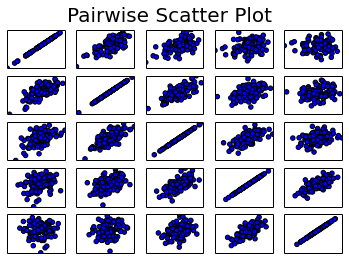

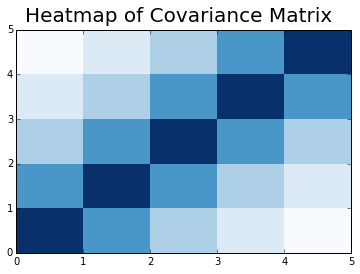

In [3]:
n_data_points = 100
n_features = 5

X = make_independent_data(n_features, n_data_points)
X, covar = make_correlated_data(n_features, 0.7, n_data_points)

fig = plt.figure()

count = 0

for ii in range(n_features):
    for jj in range(n_features):
        ax = plt.subplot(n_features, n_features, count + 1)
        plt.setp(ax, xticks=(), yticks=())    
        plt.scatter(X[:, ii], X[:, jj])  
        ax.set_xlim([np.min(X), np.max(X)])
        ax.set_ylim([np.min(X), np.max(X)])
        count += 1
        
fig.suptitle('Pairwise Scatter Plot', fontsize=20)
        
        
fig = plt.figure()
heatmap = plt.pcolor(covar, cmap=mp.cm.Blues)
fig.suptitle('Heatmap of Covariance Matrix', fontsize=20)

In [4]:
def create_data_set(n_data_points, 
                    n_features, 
                    n_noise_features, 
                    phi, 
                    signal_strength, 
                    n_train_points):
    """Create a complete data set for a regression problem

    Arguments:
    n_data_points: integer number of data points
    n_features: integer number of features that have nonzero coefficients
    n_noise_features: integer number of features that have zero coefficients
    phi: correlation parameter between features; decays are differnce in index increases
    signal_strength: mean value of nonzero coefficients
    n_train_points: number of data points to place in training set from the total n_data_points
    """
    
    # create true set of coefficients
    true_linear_model = np.concatenate((np.random.normal(size=n_features, scale=0.5) + signal_strength, 
                                        np.zeros(n_noise_features)))

    # make things the right shape
    true_linear_model = np.reshape(np.array(true_linear_model), 
                                   newshape=(n_features + n_noise_features, 1))

    # make the data now using make_correlated_data
    X, _ = make_correlated_data(n_features + n_noise_features, phi, n_data_points)

    # use the features and the coefficients to make the data
    Y_signal = np.dot(X, true_linear_model)
    Y_noise = np.reshape(np.random.normal(size=n_data_points), newshape=(n_data_points, 1))
    Y = np.add(Y_signal, Y_noise)

    Y = Y.flatten()

    # train, test split
    train_data, train_labels = X[:n_train_points], Y[:n_train_points]
    test_data, test_labels = X[n_train_points:], Y[n_train_points:]
    
    return train_data, train_labels, test_data, test_labels, true_linear_model

Now, let's run some simulations: what variables does linear regression pick up?

Is this a harder problem with correlated data?

What are some ways we can reduce estimation error?

Linear model test MSE:  0.956048401227
Estimation error for parameters:  0.95826526181


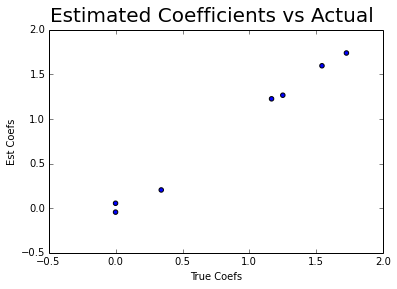

In [5]:
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(600, 5, 2, 0.75, 1, 350)

lm = LinearRegression()
lm.fit(train_data, train_labels)

lm_coef = lm.coef_

lm_test_mse = ((lm.predict(test_data) - test_labels) ** 2).mean()

print "Linear model test MSE: ", lm_test_mse

# plot estimated coefficients versus the actual coefficients
fig = plt.figure()
plt.scatter(true_linear_model, lm_coef)
fig.suptitle('Estimated Coefficients vs Actual', fontsize=20)
plt.xlabel('True Coefs')
plt.ylabel('Est Coefs') 

# these are the indices of nonzero entries of the coefficient vector
# print 'index of nonzero linear regression variables: \n', np.where(lm_coef != 0)

# what is wrong with this measure?
estimation_error = ((true_linear_model - lm_coef) ** 2).mean()

print "Estimation error for parameters: ", estimation_error

One thing that is going wrong here: we are assigning non-zero vlaues to coefficients with truly zero coefficients.

Now, we can try implementing stepwise regression, which is a simple greedy algorithm for selecting a sub model. Here's a plan:

1. Start with an empty model (no variables used)
2. For each variable not included:
a. Fit a model with that variable included, record the prediction performance
3. Add the variable that did the best in 2a to the set
4. Repeat until all variables are in the model

How could we choose how to stop?

How can we see if it is reasonable to stop?

Sequence of test set errors:
[8.1152505714215781, 2.0663414534234286, 1.420542651831044, 1.3697720981933201, 1.3861821996450621, 1.3891800092581172, 1.3932589408005642, 1.4160515124997017, 1.4851207917739373]
Differences btw steps:
[ -6.04890912e+00  -6.45798802e-01  -5.07705536e-02   1.64101015e-02
   2.99780961e-03   4.07893154e-03   2.27925717e-02   6.90692793e-02]
Final set of variables:
[2, 1, 7]
Selected coefficients; true values:
[[ 1.5765179]
 [ 1.1713402]
 [ 0.       ]]


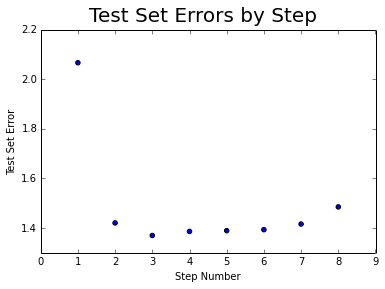

In [6]:
np.random.seed(100) # "simulation"

# generate the data set
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(150, 3, 5, 0.75, 1, 60)

# set of variables 'in' the model, and 'out' of the model
# we begin with all variables out of the model, and no variables in the model
invar = []
outvar = range(train_data.shape[1])

# begin with the null model; store the MSE
intercept = test_labels.mean()
error = ((test_labels - intercept) ** 2).mean()
errorseq = [error]

# stepwise regression loop
for jj in range(train_data.shape[1]):
    varscores = []
    
    # loop over all variables in the 'out' set
    for idx, ovar in enumerate(outvar):
        # temporarily add the variable the the in set
        vartemp = invar[:]
        vartemp.append(ovar)
        vartemp = np.array(vartemp)
        
        # check the MSE on the test set
        lm = LinearRegression()
        lm.fit(train_data[:, vartemp], train_labels)
        lm_test_mse = ((lm.predict(test_data[:, vartemp]) - test_labels) ** 2).mean()
        varscores.append(lm_test_mse)
    
    # take the variable with the smallest test set MSE
    argmin_selection = np.argmin(np.array(varscores))
    errorseq.append(varscores[argmin_selection])
    invar.append(outvar.pop(argmin_selection))
    
# the stopping rule: the first time the test set MSE goes up
adj_differences = np.array(errorseq[1:]) - np.array(errorseq[:-1])
cut_process = (np.where(adj_differences > 0)[0][0])

# results; diagnostics
print "Sequence of test set errors:\n", errorseq
print "Differences btw steps:\n", adj_differences
print "Final set of variables:\n", invar[:cut_process]

print "Selected coefficients; true values:\n", true_linear_model[invar[:cut_process]]

fig = plt.figure()
plt.scatter(range(len(errorseq))[1:], errorseq[1:])
fig.suptitle('Test Set Errors by Step', fontsize=20)
plt.xlabel('Step Number')
plt.ylabel('Test Set Error') 

Is this the only way to do variable selection? Turns out there is a way to cast this entire task as a single optimization problem, called *regularization*.

**Regularization in general**

Typical learning objectives simply optimizes the fit. It looks like (here beta are some parameters that define the model, say the coefficients in linear regression):

Objective(beta) = fit(beta)

And we do:

beta-hat = argmin(Objective(beta))

So, we choose the beta that minimizes the objective, that is, provides the best fit to the training data.

Regularization simply tweaks this by:

RegularizedObjective(beta) = fit(beta) + alpha * penalty(beta)

And, as above:

regularized-beta-hat = argmin(RegularizedObjective(beta))

So, what is the penalty? It is a way to define the complexity of beta. We'll see how complexity is defined below. But, in general, as the fit gets better, the complexity becomes higher, and so the objective nicely formalizes this tradeoff. Alpha is a constant (we'll have to pick it) that defines the strength of this tradeoff.

We can define complexity in a couple of ways: (1) large values of coefficients are one indication; (2) using many dimensions (non-zero coefficients) are another indication. Regularization can caputre both.

## L2 regularization: shrinkage

Let's explore the first type of regularization, L2 regularization. It takes the form:

Objective(beta) = fit(beta) + alpha * sum_j(beta_j^2)

Some useful docs for the following:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html


In [7]:
lm = LinearRegression()
lm.fit(train_data, train_labels)

lm_test_mse = ((lm.predict(test_data) - test_labels) ** 2).mean()

rm = Ridge(alpha=1, normalize=False)
rm.fit(train_data, train_labels)

rm_test_mse = ((rm.predict(test_data) - test_labels) ** 2).mean()

print "Linear model test MSE:     ", lm_test_mse
print "Ridge regression test MSE: ", rm_test_mse
print "Linear regression does worse on the test set: ", lm_test_mse > rm_test_mse

Linear model test MSE:      1.48512079177
Ridge regression test MSE:  1.46196350624
Linear regression does worse on the test set:  True


Now, let's see what happens to the coefficients as alpha changes. Here's an investigation for a single coefficient. What happens to other coefficients? How is this reducing complexity? You can also try out making a *regularization path plot*, see:

http://fa.bianp.net/blog/2011/ridge-regression-path/

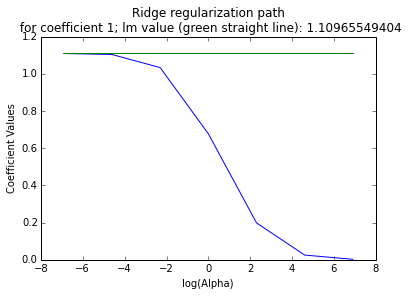

In [8]:
alpha_vec = [0.001, 0.01, .1, 1, 10, 100, 1000]
coef_idx = 1
coef_values = np.zeros(len(alpha_vec))
lm_coef_line = np.zeros(len(alpha_vec))

for aa in enumerate(alpha_vec):
    lm = LinearRegression()
    lm.fit(train_data, train_labels)

    rm = Ridge(alpha=aa[1], normalize=True)
    rm.fit(train_data, train_labels)
    
    rm_coef = rm.coef_[coef_idx]
    lm_coef = lm.coef_[coef_idx]
 
    coef_values[aa[0]] = rm_coef
    lm_coef_line[aa[0]] = lm_coef
    
plt.plot(np.log(alpha_vec), coef_values)
plt.plot(np.log(alpha_vec), lm_coef_line)
plt.title('Ridge regularization path\n for coefficient ' + str(coef_idx) + 
          '; lm value (green straight line): ' + str(lm_coef))
plt.ylabel('Coefficient Values') 
plt.xlabel('log(Alpha)') 
plt.show()

### L1 Regularization: the lasso; shrinkage and selection

Let's explore another type of regularization, L1 regularization. It takes the form:

Objective(beta) = fit(beta) + alpha * sum_j(abs(beta_j))

Some useful docs for the following:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [9]:
lm = LinearRegression()
lm.fit(train_data, train_labels)

lm_test_mse = ((lm.predict(test_data) - test_labels) ** 2).mean()

# try playing with the alpha
las = Lasso(alpha=0.05, normalize=True, max_iter=100)
las.fit(train_data, train_labels)

las_test_mse = ((las.predict(test_data) - test_labels) ** 2).mean()

print "Linear model test MSE: ", lm_test_mse
print "Lasso regression test MSE: ", las_test_mse

print "Linear regression does worse on the test set: ", lm_test_mse > las_test_mse

print true_linear_model
print lm.coef_
print las.coef_

Linear model test MSE:  1.48512079177
Lasso regression test MSE:  1.35937710571
Linear regression does worse on the test set:  True
[[ 0.12511726]
 [ 1.1713402 ]
 [ 1.5765179 ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
[ 0.16260558  1.10965549  1.83390362 -0.08488595  0.21903723 -0.19399612
  0.51742768 -0.45992937]
[ 0.01914828  1.03656152  1.64559246  0.          0.          0.          0.
 -0.        ]


[-0.07846344 -0.02075572  0.          0.          0.          0.          0.        ]


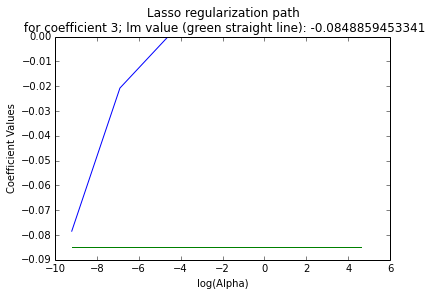

In [10]:
alpha_vec = [0.0001, 0.001, 0.01, .1, 1, 10, 100]
coef_idx = 3
coef_values = np.zeros(len(alpha_vec))
lm_coef_line = np.zeros(len(alpha_vec))

for aa in enumerate(alpha_vec):
    lm = LinearRegression()
    lm.fit(train_data, train_labels)

    las = Lasso(alpha=aa[1], normalize=True, max_iter=100)
    las.fit(train_data, train_labels)
    
    las_coef = las.coef_[coef_idx]
    lm_coef = lm.coef_[coef_idx]
 
    coef_values[aa[0]] = las_coef
    lm_coef_line[aa[0]] = lm_coef

print coef_values 

#plt.plot(np.log(alpha_vec), lm_coef_line * 0)
plt.plot(np.log(alpha_vec), coef_values)
plt.plot(np.log(alpha_vec), lm_coef_line)
plt.title('Lasso regularization path\n for coefficient ' + str(coef_idx) + 
          '; lm value (green straight line): ' + str(lm_coef))
plt.ylabel('Coefficient Values') 
plt.xlabel('log(Alpha)') 
plt.show()

### An Application: crime data

Here's a simple application using one of the UCI data sets: communities and crime.

Let's first load the data and do some basic investigations.

In [69]:
# from: https://github.com/justmarkham/DAT5/blob/master/code/18_regularization.py

########## Prepare data ##########
# read in data, remove categorical features, remove rows with missing values
import pandas as pd
crime = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data', header=None, na_values=['?'])
crime = crime.iloc[:, 5:] # get rid of columns that are the names of towns
crime.dropna(inplace=True) # drop missing values
print crime.head()

# the names of the columns
crime_names = np.genfromtxt('comm_names.txt',dtype='str')[5:, :]

# define X and y; 
# y from the last column which is the:
# ViolentCrimesPerPop: total number of violent crimes per 100K popuation (numeric - decimal) GOAL attribute (to be predicted)
# (from: https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.names)
X = crime.iloc[:, :-1]
y = crime.iloc[:, -1]

# split into train/test
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

     5     6     7     8     9     10    11    12    13    14   ...    118  \
0   0.19  0.33  0.02  0.90  0.12  0.17  0.34  0.47  0.29  0.32  ...   0.12   
16  0.15  0.31  0.40  0.63  0.14  0.06  0.58  0.72  0.65  0.47  ...   0.06   
20  0.25  0.54  0.05  0.71  0.48  0.30  0.42  0.48  0.28  0.32  ...   0.09   
21  1.00  0.42  0.47  0.59  0.12  0.05  0.41  0.53  0.34  0.33  ...   1.00   
23  0.11  0.43  0.04  0.89  0.09  0.06  0.45  0.48  0.31  0.46  ...   0.16   

     119   120   121   122   123  124   125   126   127  
0   0.26  0.20  0.06  0.04  0.90  0.5  0.32  0.14  0.20  
16  0.39  0.84  0.06  0.06  0.91  0.5  0.88  0.26  0.49  
20  0.46  0.05  0.09  0.05  0.88  0.5  0.76  0.13  0.34  
21  0.07  0.15  1.00  0.35  0.73  0.0  0.31  0.21  0.69  
23  0.12  0.07  0.04  0.01  0.81  1.0  0.56  0.09  0.63  

[5 rows x 123 columns]


In [70]:
# now, fit a few models, let's try linear regresion, ridge regression, and the lasso

# linear regression, ridge, lasso

lm = LinearRegression()
lm.fit(X_train, y_train)

lm_test_mse = ((lm.predict(X_test) - y_test) ** 2).mean()

# ridge regression
rm = Ridge(alpha=1, normalize=False)
rm.fit(X_train, y_train)

rm_test_mse = ((rm.predict(X_test) - y_test) ** 2).mean()

# lasso regression
las = Lasso(alpha=0.01, normalize=True, max_iter=100)
las.fit(X_train, y_train)

las_test_mse = ((las.predict(X_test) - y_test) ** 2).mean()

print "Linear model test MSE:     ", lm_test_mse
print "Ridge regression test MSE: ", rm_test_mse
print "Lasso regression test MSE: ", las_test_mse

Linear model test MSE:      0.054668835316
Ridge regression test MSE:  0.0265404078914
Lasso regression test MSE:  0.0392694565692


Non-zero lasso coefficients: 
[[['@attribute' 'racePctWhite' 'numeric']
  ['@attribute' 'PctKids2Par' 'numeric']]]


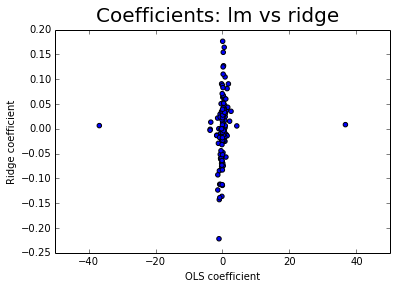

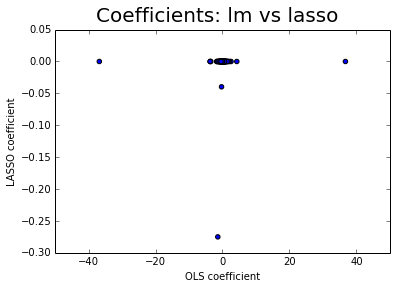

In [71]:
# what about the coefficients; what does lasso drop?

# extract coefficients
lm_coef = lm.coef_
rm_coef = rm.coef_
las_coef = las.coef_

print "Non-zero lasso coefficients: \n", crime_names[np.where(las_coef!=0), :]

# plotting
fig = plt.figure()
plt.scatter(lm_coef, rm_coef)
fig.suptitle('Coefficients: lm vs ridge', fontsize=20)
plt.xlabel('OLS coefficient')
plt.ylabel('Ridge coefficient')

fig = plt.figure()
plt.scatter(lm_coef, las_coef)
fig.suptitle('Coefficients: lm vs lasso', fontsize=20)
plt.xlabel('OLS coefficient')
plt.ylabel('LASSO coefficient') 

In [73]:
# looking at the above plot we see that there are a couple of really big coefficients
# what are these?
print "Big lm coefficients: \n"
big_coefs = np.where(abs(lm_coef) > 5)

print lm_coef[big_coefs]
print crime_names[big_coefs, :]
print 'correlation between the big coefficients features: \n'
print np.corrcoef(X_train.as_matrix()[:, big_coefs[0][0]],
                  X_train.as_matrix()[:, big_coefs[0][1]])

Big lm coefficients: 

[-36.79412053  36.71529568]
[[['@attribute' 'LemasSwFTPerPop' 'numeric']
  ['@attribute' 'PolicPerPop' 'numeric']]]
correlation between the big coefficients features: 

[[ 1.          0.99999224]
 [ 0.99999224  1.        ]]


Computing regularization path using the lasso...
Computing regularization path using the positive lasso...
Computing regularization path using the elastic net...
Computing regularization path using the positive elastic net...


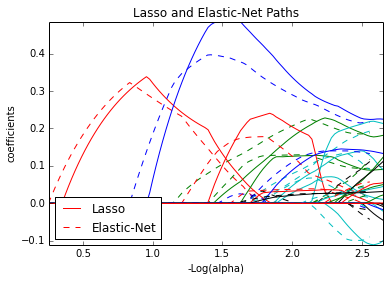

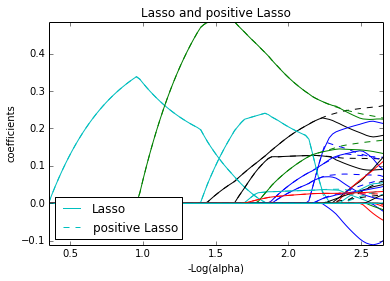

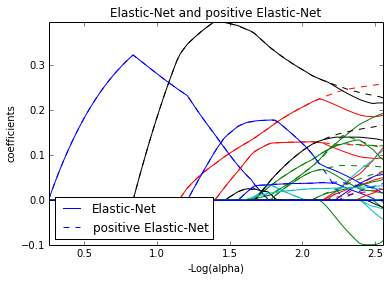

In [14]:
# coefficient paths; from
# http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py
from sklearn.linear_model import lasso_path, enet_path
from itertools import cycle

eps = 5e-3  # the smaller it is the longer is the path
l1_rat = 0.8

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X_train.as_matrix(), y_train.as_matrix(), eps, fit_intercept=False)

print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(
    X_train.as_matrix(), y_train.as_matrix(), eps, positive=True, fit_intercept=False)
print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(
    X_train.as_matrix(), y_train.as_matrix(), eps=eps, l1_ratio=l1_rat, fit_intercept=False)

print("Computing regularization path using the positive elastic net...")
alphas_positive_enet, coefs_positive_enet, _ = enet_path(
    X_train.as_matrix(), y_train.as_matrix(), eps=eps, l1_ratio=l1_rat, positive=True, fit_intercept=False)

# Display results

plt.figure(1)
ax = plt.gca()

colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')


plt.figure(2)
ax = plt.gca()
neg_log_alphas_positive_lasso = -np.log10(alphas_positive_lasso)
for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_positive_lasso, coef_pl, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and positive Lasso')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'positive Lasso'), loc='lower left')
plt.axis('tight')


plt.figure(3)
ax = plt.gca()
neg_log_alphas_positive_enet = -np.log10(alphas_positive_enet)
for (coef_e, coef_pe, c) in zip(coefs_enet, coefs_positive_enet, colors):
    l1 = plt.plot(neg_log_alphas_enet, coef_e, c=c)
    l2 = plt.plot(neg_log_alphas_positive_enet, coef_pe, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic-Net and positive Elastic-Net')
plt.legend((l1[-1], l2[-1]), ('Elastic-Net', 'positive Elastic-Net'),
           loc='lower left')
plt.axis('tight')
plt.show()

(array([ 97, 103]),)
[ -3.67848868e+01  -3.67019894e+01  -3.58929335e+01  -2.93978934e+01
  -1.03164163e+01  -1.17397806e+00  -4.39118998e-02   8.28881447e-03
   6.55072592e-04   1.14778395e-03   5.47032226e-03   1.53614421e-03]
[ 0.20564601  0.20542931  0.20326212  0.18163945 -0.00174374 -0.          0.
  0.          0.          0.          0.          0.        ]


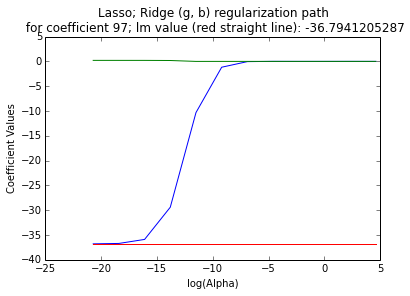

In [68]:
# investigate those two highly correlated features; what do lasso, ridge do to them?

print big_coefs

alpha_vec = [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, .1, 1, 10, 100]
coef_idx = 97
rm_coef_values = np.zeros(len(alpha_vec))
las_coef_values = np.zeros(len(alpha_vec))
lm_coef_line = np.zeros(len(alpha_vec))

for aa in enumerate(alpha_vec):
    lm = LinearRegression()
    lm.fit(X_train, y_train)

    rm = Ridge(alpha=aa[1], normalize=True)
    rm.fit(X_train, y_train)
    
    las = Lasso(alpha=aa[1], normalize=True, max_iter=100)
    las.fit(X_train, y_train)
    
    rm_coef = rm.coef_[coef_idx]
    las_coef = las.coef_[coef_idx]
    lm_coef = lm.coef_[coef_idx]
 
    rm_coef_values[aa[0]] = rm_coef
    las_coef_values[aa[0]] = las_coef
    lm_coef_line[aa[0]] = lm_coef

print rm_coef_values 
print las_coef_values 

#plt.plot(np.log(alpha_vec), lm_coef_line * 0)
plt.plot(np.log(alpha_vec), rm_coef_values)
plt.plot(np.log(alpha_vec), las_coef_values)
plt.plot(np.log(alpha_vec), lm_coef_line)
plt.title('Lasso; Ridge (g, b) regularization path\n for coefficient ' + str(coef_idx) + 
          '; lm value (red straight line): ' + str(lm_coef))
plt.ylabel('Coefficient Values') 
plt.xlabel('log(Alpha)') 
plt.show()

All these paths and investigations into the effect of alpha for both ridge and lasso are fine, but how can we choose the best alpha? We'll use cross validation here.

[ 0.12186653  0.09101185  0.06033518  0.04606295  0.03513292  0.02963664
  0.03813776  0.06912388]
{'alpha': 0.0001}
argmin:  10.0


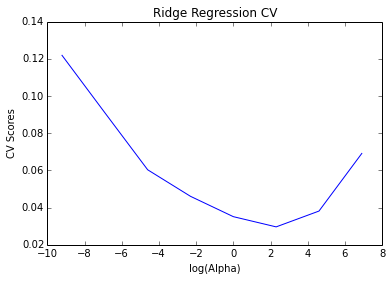

[ 0.05937681  0.05693644  0.04282406  0.03027517  0.04878616  0.08240518
  0.08240518  0.08240518]
{'alpha': 0.1}
argmin:  0.001


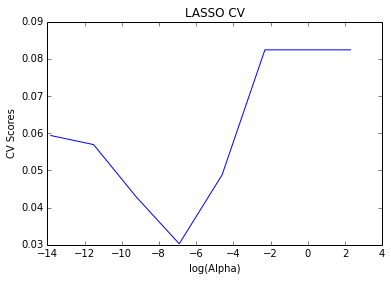

In [74]:
# cross validation to select the best alpha parameters

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

# ridge regression setup parameters and fit
rm_params = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}

# run cross validation
rm = Ridge(normalize=False)
rm_grid = GridSearchCV(rm, rm_params, scoring=make_scorer(mean_squared_error)) 
rm_grid.fit(X_train, y_train)

print rm_grid.cv_results_['mean_test_score']
print rm_grid.best_params_ ## why is this wrong?
print 'argmin: ', rm_params['alpha'][np.argmin(rm_grid.cv_results_['mean_test_score'])]

best_rm_alpha = rm_params['alpha'][np.argmin(rm_grid.cv_results_['mean_test_score'])]

# plot cross validation curve
plt.plot(np.log(rm_params['alpha']), rm_grid.cv_results_['mean_test_score'])
plt.title('Ridge Regression CV')
plt.ylabel('CV Scores') 
plt.xlabel('log(Alpha)') 
plt.show()

# lasso regression setup parameters and fit
las_params = {'alpha':[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}

# run cross validation
las = Lasso(normalize=True, max_iter=100)
las_grid = GridSearchCV(las, las_params, scoring=make_scorer(mean_squared_error)) 
las_grid.fit(X_train, y_train)

print las_grid.cv_results_['mean_test_score']
print las_grid.best_params_ ## why is this wrong?
print 'argmin: ', las_params['alpha'][np.argmin(las_grid.cv_results_['mean_test_score'])]

best_las_alpha = las_params['alpha'][np.argmin(las_grid.cv_results_['mean_test_score'])]

# plot cross validation curve
plt.plot(np.log(las_params['alpha']), las_grid.cv_results_['mean_test_score'])
plt.title('LASSO CV')
plt.ylabel('CV Scores') 
plt.xlabel('log(Alpha)') 
plt.show()

In [81]:
# finally, re run all the models using the best alpha values as found by cross validation and plot the results

lm = LinearRegression()
lm.fit(X_train, y_train)

lm_test_mse = ((lm.predict(X_test) - y_test) ** 2).mean()

rm_best = Ridge(normalize=False, alpha = best_rm_alpha)
rm_best.fit(X_train, y_train)
rm_test_mse = ((rm_best.predict(X_test) - y_test) ** 2).mean()

las_best = Lasso(normalize=True, max_iter=100, alpha = best_las_alpha)
las_best.fit(X_train, y_train)
las_test_mse = ((las_best.predict(X_test) - y_test) ** 2).mean()

print "Linear model test MSE:     ", lm_test_mse
print "Ridge regression test MSE @ best CV alpha: ", rm_test_mse
print "Lasso regression test MSE @ best CV alpha: ", las_test_mse

# which coefficients do we keep?
print "Non-zero lasso coefficients: \n", crime_names[np.where(las_best.coef_!=0), :][0]

print "\n\nDropped (zero) lasso coefficients: \n", crime_names[np.where(las_best.coef_==0), :]

Linear model test MSE:      0.054668835316
Ridge regression test MSE @ best CV alpha:  0.0258931855455
Lasso regression test MSE @ best CV alpha:  0.0255937895125
Non-zero lasso coefficients: 
[['@attribute' 'racepctblack' 'numeric']
 ['@attribute' 'racePctWhite' 'numeric']
 ['@attribute' 'pctWInvInc' 'numeric']
 ['@attribute' 'PctPopUnderPov' 'numeric']
 ['@attribute' 'PctUnemployed' 'numeric']
 ['@attribute' 'PctEmplManu' 'numeric']
 ['@attribute' 'MalePctDivorce' 'numeric']
 ['@attribute' 'TotalPctDiv' 'numeric']
 ['@attribute' 'PctFam2Par' 'numeric']
 ['@attribute' 'PctKids2Par' 'numeric']
 ['@attribute' 'PctHousLess3BR' 'numeric']
 ['@attribute' 'NumStreet' 'numeric']
 ['@attribute' 'PolicReqPerOffic' 'numeric']
 ['@attribute' 'RacialMatchCommPol' 'numeric']
 ['@attribute' 'PctPolicAsian' 'numeric']
 ['@attribute' 'PolicCars' 'numeric']
 ['@attribute' 'LemasGangUnitDeploy' 'numeric']
 ['@attribute' 'LemasPctOfficDrugUn' 'numeric']]


Dropped (zero) lasso coefficients: 
[[['@attrib